# TP 3 - Chevrier & Troadec & Artaud




## Import 

In [1]:
%%bash
curl -O http://pageperso.lif.univ-mrs.fr/~alexis.nasr/Ens/MASCO_AA/EncodeDecode.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1119  100  1119    0     0   1500      0 --:--:-- --:--:-- --:--:--  1497


In [2]:
from EncodeDecode import EncodeDecode
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GRU
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
%%bash
curl -O http://pageperso.lif.univ-mrs.fr/~alexis.nasr/Ens/MASCO_AA/lemmatisation_data.tgz
tar xvfz lemmatisation_data.tgz

alphabet.txt
lemmatisation_test_A.txt
lemmatisation_test_N.txt
lemmatisation_test_origin.txt
lemmatisation_test.txt
lemmatisation_test_V.txt
lemmatisation_train_A.txt
lemmatisation_train_N.txt
lemmatisation_train_origin.txt
lemmatisation_train.txt
lemmatisation_train_V.txt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3044k  100 3044k    0     0  2885k      0  0:00:01  0:00:01 --:--:-- 2885k


## Visualisation des données 

In [4]:
ed = EncodeDecode("alphabet.txt")

print(ed.encode('a'))
oneHot = ed.oneHotEncode('a')
print(oneHot)
print(ed.oneHotDecode(oneHot))


1
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
a


In [5]:
file = open("lemmatisation_train_A.txt","r")
print(file.readline())
line = file.readline()
file.close()

seconde##################	second###################	A



In [6]:
print(line.split())

['bonne####################', 'bon######################', 'A']


In [7]:
file = open("lemmatisation_train_origin.txt","r")
print(file.readline())
file.close()

Certes	certes	ADV



In [8]:
file = open("lemmatisation_train.txt","r")
print(file.readline())
file.close()

Certes###################	certes###################	ADV



## Traitement des données 

In [9]:
def traitement_categ(fichier : str) : 
    """Transforme les mots en liste de OneHot, chaque lettre est associée à une liste de OneHot de 66 bit, chaque mot est une liste 
    de taille 25"""
    x = []  # Liste de X
    y = []  # Liste de Y 
    file = open(fichier,"r")
    for line in file:
        l = line.split()
        xx = []
        for i in l[0] : 
            xx.append(ed.oneHotEncode(i))  
        x.append(xx)
        yy = []
        for i in l[1] : 
            yy.append(ed.oneHotEncode(i))
        y.append(yy)       
    file.close()
    x = np.asarray(x)
    y = np.asarray(y)
    return x,y

In [10]:
def traitement_gene(fichier : str, nb_train = 100) : # nb_train est le nombre d'exemple que vont contenir X et y train
    x = []
    y = []
    file = open(fichier,"r")
    for i in range(nb_train) : 
        line = file.readline()
        l = line.split()
        
        if len(l[2]) == 3 :

          xx = []

          for j in l[0] : 
            xx.append(ed.oneHotEncode(j))

          for j in l[2] :  # catégories 
              if j != "+" : 
                xx.append(ed.oneHotEncode(j)) # General
              else : 
                xx.append(ed.oneHotEncode("#"))
          x.append(xx)

          yy = []
          for j in l[1] : 
              yy.append(ed.oneHotEncode(j))
          yy.append(ed.oneHotEncode("#"))
          yy.append(ed.oneHotEncode("#"))
          yy.append(ed.oneHotEncode("#"))
          y.append(yy)    

        elif len(l[2]) == 1 :

          xx = [] 

          for j in l[0] : 
            xx.append(ed.oneHotEncode(j))

          xx.append(ed.oneHotEncode(l[2]))
          xx.append(ed.oneHotEncode("#"))
          xx.append(ed.oneHotEncode("#"))     
        
          x.append(xx)

          yy = []
          for j in l[1] : 
              yy.append(ed.oneHotEncode(j))
          yy.append(ed.oneHotEncode("#"))
          yy.append(ed.oneHotEncode("#"))
          yy.append(ed.oneHotEncode("#"))
          y.append(yy)   
              
    file.close()
    x = np.asarray(x)
    y = np.asarray(y)
    return x,y

In [11]:
def decode(y) : 
  """Prends en entrée une matrice de mot(s) en OneHotEncode et renvoie un mot ou une liste de mot en str"""
  if y.shape == (25, 66) or y.shape == (28, 66):
        lemme = ""
        for i in y : 
            lemme += ed.oneHotDecode(i)
  else : 
      lemme = []
      for j in y : 
          mot = ""
          for i in j : 
              mot += ed.oneHotDecode(i)
          lemme.append(mot)
  return lemme

## Lemmatiseur catégoriel

Le modèle doit reconnaitre une forme et en donner le lemme  (couvent) → couver. Chaque modèle est spécifique à la catégorie. 


### Données 

In [12]:
# Adjectifs
X_train_A, y_train_A = traitement_categ("lemmatisation_train_A.txt")
X_test_A, y_test_A = traitement_categ("lemmatisation_test_A.txt")

# Verbes
X_train_V, y_train_V = traitement_categ("lemmatisation_train_V.txt")
X_test_V, y_test_V = traitement_categ("lemmatisation_test_V.txt")

# Noms
X_train_N, y_train_N = traitement_categ("lemmatisation_train_N.txt")
X_test_N, y_test_N = traitement_categ("lemmatisation_test_N.txt")

In [13]:
print(X_train_A.shape, y_train_A.shape)

(18283, 25, 66) (18283, 25, 66)


### Modèle 

In [14]:
def model() :
    mod = Sequential()
    mod.add(keras.Input(shape=(25,66)))
    mod.add(GRU(units = 66, return_sequences=True,
                activation="tanh", recurrent_activation="sigmoid"))
    mod.add(layers.Dense(66))
    mod.compile(loss= 'MeanSquaredError',       #'categorical_crossentropy', <- Mauvais résultats sur jeu de données de Verbes      
              optimizer='adam',
              metrics=['accuracy']) 
    return mod

- **Train**

In [15]:
# Adjectifs 
model_A = model()
model_A.fit(X_train_A, y_train_A, epochs= 2) # Epochs = 2 pour avoir de meilleurs résultats 

Epoch 1/2
572/572 [==============================] - 11s 16ms/step - loss: 0.0040 - accuracy: 0.8601
Epoch 2/2
572/572 [==============================] - 9s 15ms/step - loss: 5.4602e-04 - accuracy: 0.9820


In [16]:
# Verbes 
model_V = model()
model_V.fit(X_train_V, y_train_V, epochs = 3)

Epoch 1/3
950/950 [==============================] - 17s 16ms/step - loss: 0.0041 - accuracy: 0.8260
Epoch 2/3
950/950 [==============================] - 15s 15ms/step - loss: 0.0013 - accuracy: 0.9518
Epoch 3/3
950/950 [==============================] - 15s 16ms/step - loss: 9.2044e-04 - accuracy: 0.9669


In [17]:
# Noms
model_N = model()
model_N.fit(X_train_N, y_train_N)

2047/2047 [==============================] - 34s 16ms/step - loss: 0.0018 - accuracy: 0.9419


- **Test**


In [18]:
# Adjectifs 
ev_A = model_A.evaluate(X_test_A,y_test_A)
print("Le model A présente une accuracy à {1} et un loss à {0}".format(ev_A[0], ev_A[1]))

76/76 [==============================] - 1s 5ms/step - loss: 4.0008e-04 - accuracy: 0.9866
Le model A présente une accuracy à 0.9865617156028748 et un loss à 0.00040007574716582894


In [19]:
# Verbes 
ev_V = model_V.evaluate(X_test_V,y_test_V)
print("Le model V présente une accuracy à {1} et un loss à {0}".format(ev_V[0], ev_V[1]))

131/131 [==============================] - 1s 6ms/step - loss: 8.0916e-04 - accuracy: 0.9709
Le model V présente une accuracy à 0.9708577990531921 et un loss à 0.0008091619820334017


In [20]:
# Noms 
ev_N = model_N.evaluate(X_test_N,y_test_N)
print("Le model N présente une accuracy à {1} et un loss à {0}".format(ev_N[0], ev_N[1]))

263/263 [==============================] - 2s 6ms/step - loss: 2.3791e-04 - accuracy: 0.9923
Le model N présente une accuracy à 0.9922882914543152 et un loss à 0.00023790918930899352


- **Exemple de traitement de données par les modèles**

- Modèle A 

In [21]:
print("Forme : ", decode(X_test_A[:5]))
y_pred_A = model_A.predict(X_test_A[:5])
print("Lemme : ", decode(y_test_A[:5]))
print("Lemme prédit : ",decode(y_pred_A))

Forme :  ['espagnole################', 'première#################', 'espagnole################', 'premiers#################', 'financiers###############']
Lemme :  ['espagnol#################', 'premier##################', 'espagnol#################', 'premier##################', 'financier################']
Lemme prédit :  ['espagnol#################', 'premier##################', 'espagnol#################', 'premier##################', 'financier################']


On peut relever une erreur percutante pour le modèle A : les "e" à la fin des lemmes sont oubliés. 

- Modèle V 

In [22]:
print("Forme : ", decode(X_test_V[:5]))
y_pred_V = model_A.predict(X_test_V[:5])
print("Lemme : ", decode(y_test_V[:5]))
print("Lemme prédit : ",decode(y_pred_V))

Forme :  ['vient####################', 'hispaniser###############', 'étendre##################', 'resserrant###############', 'est######################']
Lemme :  ['venir####################', 'hispaniser###############', 'étendre##################', 'resserrer################', 'être#####################']
Lemme prédit :  ['vient####################', 'hispaniser###############', 'étendre##################', 'resserrant###############', 'est######################']


Ici, dans les quelques mots parcourus ont peut voir que le les lettres "ss" ont été appris comme ##, cette suite de lettre a donc été oublié par le modèle. 

- Modèle N 

In [23]:
print("Forme : ", decode(X_test_N[:5]))
y_pred_N = model_N.predict(X_test_N[:5])
print("Lemme : ", decode(y_test_N[:5]))
print("Lemme prédit : ",decode(y_pred_N))

Forme :  ['filiale##################', 'participations###########', 'Espagne##################', 'liens####################', 'Caixa####################']
Lemme :  ['filiale##################', 'participation############', 'Espagne##################', 'lien#####################', 'Caixa####################']
Lemme prédit :  ['filiale##################', 'participation############', 'Espagne##################', 'lien#####################', 'Caixa####################']


Ce modèle ne présente aucune erreur sur les quelques mots parcourus.

- **Visualisation des erreurs**

In [24]:
def visu_err(y_t, y_p,x_t) :
  """Affiche le lemme correct et celui prédit par raaport au mot """
  for t, p, x in zip(y_t, y_p, x_t) : 
    if decode(t) != decode(p) : 
      print("Le lemme correcte est ", decode(t), " alors que le lemme donné est ", decode(p), "le mot de départ étant ", decode(x))

In [25]:
def visu_correct(y_t, y_p,x_t) :
  """Affiche les lemme pour un mot lorsque ce dernier est correct """
  for t, p, x in zip(y_t, y_p, x_t) : 
    if decode(t) == decode(p) : 
      print("Le lemme correcte est ", decode(t), "le mot de départ étant ", decode(x))

- Modèle A 


In [26]:
visu_err(y_test_A, model_A.predict(X_test_A[:20]), X_test_A)

Le lemme correcte est  concessionnaire##########  alors que le lemme donné est  conce##ionnaire########## le mot de départ étant  concessionnaire##########
Le lemme correcte est  exécutif#################  alors que le lemme donné est  exécutiv################# le mot de départ étant  exécutive################


- Modèle V

In [27]:
visu_err(y_test_V, model_V.predict(X_test_V[:20]), X_test_V)

Le lemme correcte est  venir####################  alors que le lemme donné est  vinir#################### le mot de départ étant  vient####################
Le lemme correcte est  étendre##################  alors que le lemme donné est  êtendre################## le mot de départ étant  étendre##################
Le lemme correcte est  resserrer################  alors que le lemme donné est  resserr################## le mot de départ étant  resserrant###############
Le lemme correcte est  détenir##################  alors que le lemme donné est  détien################### le mot de départ étant  détient##################
Le lemme correcte est  détenir##################  alors que le lemme donné est  détiendre################ le mot de départ étant  détiendra################
Le lemme correcte est  détenir##################  alors que le lemme donné est  détiendre################ le mot de départ étant  détiendra################
Le lemme correcte est  réunir###################  alors que le l

In [28]:
visu_correct(y_test_V, model_V.predict(X_test_V[:20]), X_test_V)

Le lemme correcte est  hispaniser############### le mot de départ étant  hispaniser###############
Le lemme correcte est  être##################### le mot de départ étant  est######################
Le lemme correcte est  lier##################### le mot de départ étant  liée#####################
Le lemme correcte est  prendre################## le mot de départ étant  prend####################
Le lemme correcte est  céder#################### le mot de départ étant  cède#####################
Le lemme correcte est  conserver################ le mot de départ étant  conserve#################
Le lemme correcte est  porter################### le mot de départ étant  portées##################
Le lemme correcte est  devoir################### le mot de départ étant  devrait##################
Le lemme correcte est  être##################### le mot de départ étant  être#####################


- Modèle N

In [29]:
visu_err(y_test_N, model_N.predict(X_test_N[:20]), X_test_N)

Le lemme correcte est  péninsule################  alors que le lemme donné est  pénin#ule################ le mot de départ étant  péninsule################
Le lemme correcte est  société##################  alors que le lemme donné est  Société################## le mot de départ étant  Société##################
Le lemme correcte est  eau######################  alors que le lemme donné est  eaux##################### le mot de départ étant  eaux#####################


In [30]:
visu_correct(y_test_N, model_N.predict(X_test_N[:20]), X_test_N)

Le lemme correcte est  filiale################## le mot de départ étant  filiale##################
Le lemme correcte est  participation############ le mot de départ étant  participations###########
Le lemme correcte est  Espagne################## le mot de départ étant  Espagne##################
Le lemme correcte est  lien##################### le mot de départ étant  liens####################
Le lemme correcte est  Caixa#################### le mot de départ étant  Caixa####################
Le lemme correcte est  caisse################### le mot de départ étant  caisse###################
Le lemme correcte est  épargne################## le mot de départ étant  épargne##################
Le lemme correcte est  établissement############ le mot de départ étant  établissements###########
Le lemme correcte est  Barcelone################ le mot de départ étant  Barcelone################
Le lemme correcte est  SGAB##################### le mot de départ étant  SGAB#####################
Le lemme c

###Conclusion des lemmatiseurs catégoriels

Ces trois lemmatiseurs ont de bons taux d'accuracy, tous proches de 1. Cependant, on peut tout de même observer une différence entre les performances de chaque lemmatiseur : en effet, le modèle N semble être le plus performant et le modèle V le moins performant.  
Cette différence peut s'expliquer du fait que le modèle V a un plus gros travail à réaliser par rapport aux deux autres modèles. Effectivement, la forme verbale présente plus de diversités que les noms ou les adjectifs et les possibilités de se tromper sur l'infinitif d'un verbe sont donc accrues.  
Aussi, le modèle N présente un taux d'accuracy supérieur au modèle A pour des raisons similiaires.

## Lemmatiseur général

Le modèle doit reconnaitre une forme et en donner le lemme  (couvent, V) → couver.

### Données 

In [31]:
f = open('lemmatisation_train.txt', 'r')
text=f.readlines()
NumberOfLine = len(text)
f.close()
print("Le fichier contient ",NumberOfLine, "exemples à apprendre au modèle")

Le fichier contient  209271 exemples à apprendre au modèle


In [32]:
nb_train = 25000 # on coupe le jeu de données d'entrainement car il est trop grand pour être traité d'un seul coup
nb_test = 10000 # les catégories de test sont triées donc il y aura moins de valeur de test en réalité 

In [33]:
X_train, y_train = traitement_gene("lemmatisation_train.txt", nb_train)  
X_test, y_test = traitement_gene("lemmatisation_test.txt", nb_test )  
X_train.shape

(24472, 28, 66)

### Modèle 


In [34]:
def model_general() :
    mod = Sequential()
    mod.add(keras.Input(shape=(28,66)))
    mod.add(GRU(units = 66, return_sequences=True,
                activation="tanh", recurrent_activation="sigmoid"))
    mod.add(layers.Dense(66))
    mod.compile(loss= 'MeanSquaredError',             
              optimizer='adam',
              metrics=['accuracy']) 
    return mod

- **Train**

In [35]:
model_gene = model_general()
model_gene.fit(X_train, y_train)

765/765 [==============================] - 15s 17ms/step - loss: 0.0032 - accuracy: 0.8938


- **Test**

In [36]:
ev_gene = model_gene.evaluate(X_test,y_test)
print("Le model présente une accuracy à {1} et un loss à {0}".format(ev_gene[0], ev_gene[1]))

306/306 [==============================] - 2s 6ms/step - loss: 7.1560e-04 - accuracy: 0.9739
Le model présente une accuracy à 0.9739189743995667 et un loss à 0.0007155959028750658


### Résultats


In [37]:
def dic_categ(x) : 
  """Renvoie une liste des catégories présente dans le jeu de données"""
    dic = []
    for i in x : 
        cat = ed.oneHotDecode(i[25])+ ed.oneHotDecode(i[26])+ ed.oneHotDecode(i[27])
    if cat not in dic : 
        dic.append(cat)
    return dic

In [38]:
categories = dic_categ(X_train)
print("Les categories possible sont : ",categories)

Les categories possible sont :  ['ADV', 'PRO', 'V##', 'D##', 'A##', 'N##', 'P##', 'P#D', 'C##', 'I##']


In [39]:
def err_categ(y_t, y_p,x_t,categ) :
  """Renvoie une liste des erreurs par catégorie ainsi que le nombre de mot de chaque catégories """
  mat = [0 for i in range(len(categ))]
  ind = []
  nb = [0 for i in range(len(categ))] # liste du nombre de chaque catégories au total
  
  for xt in x_t : 
    ind.append(categ.index(ed.oneHotDecode(xt[25])+ ed.oneHotDecode(xt[26])+ ed.oneHotDecode(xt[27])))
  for t, p, i in zip(y_t, y_p, ind) : 
    nb[i] += 1 
    if decode(t) != decode(p) : 
      mat[i] += 1 
  return mat,nb
      

In [40]:
y_pred = model_gene.predict(X_test)
nb_erreur_categ, total_categ = err_categ(y_test, y_pred ,X_test,categories)

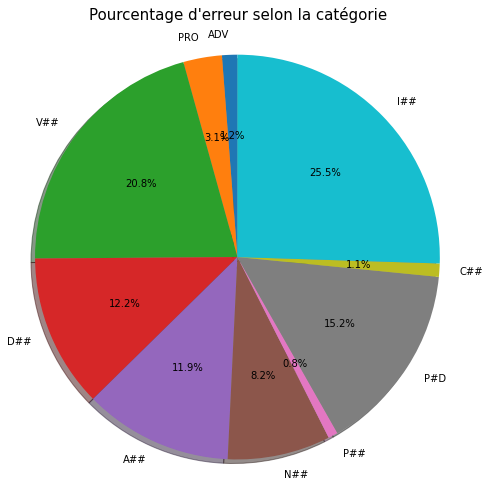

In [41]:
name = categories
data = [nb_erreur_categ[i]/total_categ[i] for i in range(len(categories)) ] # fréquence d'erreur par catégorie 
plt.figure(figsize=(8,8))

plt.pie(data,  labels=name, autopct='%1.1f%%', startangle=90, shadow=True)
plt.axis('equal')
plt.title("Pourcentage d'erreur selon la catégorie", pad=20, fontsize = 15)
plt.show()

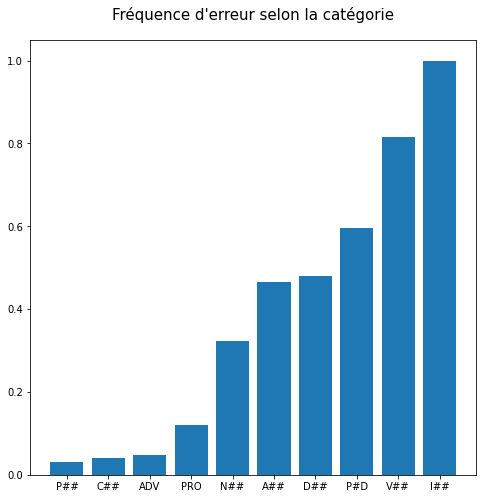

In [42]:
datat = sorted(data) 

def f(a, LL = datat, L=data):
    return LL.index(L[name.index(a)])

namet=sorted(name, key = f)

plt.figure(figsize=(8,8))
plt.bar(namet, datat)
plt.title("Fréquence d'erreur selon la catégorie", pad=20, fontsize = 15)
plt.show() 

In [43]:
print("L'erreur sur la catégorie ",namet[-1], " est de ", datat[-1], " sur un total de ",total_categ[categories.index("I##")])

L'erreur sur la catégorie  I##  est de  1.0  sur un total de  4


L'erreur sur la catégorie I## peut s'expliquer par le nombre très faible d'exemple dans les données de test. 

### Visualisation des résultats 

In [44]:
visu_err(y_test[0:20], y_pred[0:20],X_test[0:20])

Le lemme correcte est  venir#######################  alors que le lemme donné est  vient####################### le mot de départ étant  vient####################V##
Le lemme correcte est  son#########################  alors que le lemme donné est  sa########################## le mot de départ étant  sa#######################D##
Le lemme correcte est  espagnol####################  alors que le lemme donné est  e#pagnole################### le mot de départ étant  espagnole################A##
Le lemme correcte est  son#########################  alors que le lemme donné est  se########################## le mot de départ étant  ses######################D##
Le lemme correcte est  participation###############  alors que le lemme donné est  participations############## le mot de départ étant  participations###########N##
Le lemme correcte est  Espagne#####################  alors que le lemme donné est  espagne##################### le mot de départ étant  Espagne##################N##
Le lemme c

In [45]:
visu_correct(y_test[0:20], y_pred[0:20],X_test[0:20])

Le lemme correcte est  hispaniser################## le mot de départ étant  hispaniser###############V##
Le lemme correcte est  filiale##################### le mot de départ étant  filiale##################N##
Le lemme correcte est  et########################## le mot de départ étant  et#######################C##
Le lemme correcte est  étendre##################### le mot de départ étant  étendre##################V##
Le lemme correcte est  en########################## le mot de départ étant  en#######################P##
Le lemme correcte est  tout######################## le mot de départ étant  tout#####################ADV
Le lemme correcte est  en########################## le mot de départ étant  en#######################P##
Le lemme correcte est  avec######################## le mot de départ étant  avec#####################P##


### Conclusion du lemmatiseur général

En observant ces deux graphiques ci-dessus on peut voir que, bien que la performance globale du modèle soit correcte, il y a des disparités en fonction des catégories de mots. En effet, les interjections et les verbes sont les catégories qui génèrent le plus d'erreurs tandis que les prépositions et les conjonctions sont les catégories générant le moins d'erreurs. 


La catégorie des interjections est celle qui à le plus gros pourcentage d'erreur ainsi que la plus grosse fréquence d'erreur : ceci peut s'expliquer par la difficulté pour le modèle de distinguer les petites différences entre les différentes interjections. Effectivement, il n'y a parfois qu'une lettre de différence comme par exemple pour "Ah", "Eh", "Oh", etc. Aussi, quelques unes peuvent s'écrire dans les deux sens comme par exemple "Ah" et "Ha", "Eh" et "He" ce qui ajoute une difficulté de reconnaissance du lemme, d'autant plus qu'il y a peu d'exemples de cette catégorie dans les données de test.  

En ce qui concerne les verbes, qui est la deuxième catégorie avec les plus gros pourcentage et fréquence d'erreur, c'est le même problème qu'a rencontré le lemmatiseur catégoriel : les nombreuses formes possible des verbes rendent sûrement difficile la reconnaissance de la forme infinitive et donc du lemme.

On peut aussi observer des erreurs assez étonnante de notre lemmatisateur général par rapport à notre lémmatisateur catégoriel sur les majuscules. En effet, on peut voir qu'un certain nombre d'erreurs se situent sur les noms propre, commençant par une majuscules, ou sur les abréviations, que l'on écrit en majuscules. Les erreurs sont quasiment systématiques, même si certains noms propres et certaines abréviations sont traitées correctement, alors que nous avons vu que le lemmatisateur catégoriel était très efficace sur ce type de mots.
Cela peut être dû à un faible nombre de majuscules dans les données d'apprentissage. Peut-être un nombre plus grand de majuscules dans ces données pourrait solver ce problème.
  
Ainsi les catégories où les prédictions du modèle sont les plus justes sont donc les prépositions et les conjonctions. Ceci peut s'expliquer par la forme très peu variable de ces deux catégories : la forme présentée au modèle sera, pour la grande majorité, le lemme à prédire. Le travail du modèle est ainsi amoindri et les erreurs sont par conséquent moins présentes.

Le lemmatisateur général semble donc avoir encore quelques difficultés à traiter des formes très différentes de mots (noms, verbes, etc.). Peut-être un apprentissage sur de plus grand jeux de données (que nous n'avons pas fait ici car les temps de traitement sont alors très longs) pourrait solver ce problème.
Il faudrait  donc arriver à optimiser encore le réseau et le temps de traitement des données. On sait d'ailleurs que le format de nos données est très lourd, peut-être leur optimisation permettrait des temps de traitement plus faibles car des données plus légères.

## Pour aller plus loin 

Nous avons voulu comparer les performances des modèles général et catégoriel sur les catégories N, V et A. 

Pour cela, nous allons entrainer le modèle catégoriel avec le même nombre d'exemple que le général pour chaque catégorie. Pour tester le modèle général nous allons utiliser un jeu de données composées des jeux de tests de V, N et A. 

**Préparation des données**

In [46]:
def nb_per_categ(x_t, categ) :
  """Renvoie une liste des erreurs par catégorie ainsi que le nombre de mots de chaque catégorie """
  ind = []
  nb = [0 for i in range(len(categ))] # liste du nombre de chaque catégorie au total
  for xt in x_t : 
    ind.append(categ.index(ed.oneHotDecode(xt[25])+ ed.oneHotDecode(xt[26])+ ed.oneHotDecode(xt[27])))
  for i in ind : 
    nb[i] += 1 
  return nb

In [47]:
nb_categ = nb_per_categ(X_train, categories)
print( "Il y a", nb_categ[categories.index("A##")], "de A")
print( "Il y a", nb_categ[categories.index("V##")], "de V")
print( "Il y a", nb_categ[categories.index("N##")], "de N")

Il y a 2255 de A
Il y a 3580 de V
Il y a 7792 de N


In [48]:
A = ed.oneHotEncode("A")
V = ed.oneHotEncode("V")
N = ed.oneHotEncode("N")
dieze = ed.oneHotEncode("#")

In [49]:
X_test_conf = np.concatenate(
    (np.insert(X_test_A[:1000], [25], [[A, dieze, dieze] for i in range(1000)], axis = 1 ),
     np.insert(X_test_V[:1000], [25], [[V, dieze, dieze] for i in range(1000)], axis = 1 ), 
     np.insert(X_test_N[:1000], [25], [[N, dieze, dieze] for i in range(1000)], axis = 1 )
     ))
y_test_conf = np.concatenate((
    np.insert(y_test_A[:1000], [25], [[dieze, dieze, dieze] for i in range(1000)], axis = 1 ),
    np.insert(y_test_V[:1000], [25], [[dieze, dieze, dieze] for i in range(1000)], axis = 1 ), 
    np.insert(y_test_N[:1000], [25], [[dieze, dieze, dieze] for i in range(1000)], axis = 1 )
    ))
#X_test_conf, y_test_conf = shuffle(X_test_conf, y_test_conf, random_state = 42)

**Entrainement des modèles catégoriels**


In [50]:
model_A = model()
model_A.fit(X_train_A[:nb_categ[categories.index("A##")]], y_train_A[:nb_categ[categories.index("A##")]])

71/71 [==============================] - 3s 16ms/step - loss: 0.0096 - accuracy: 0.5963


In [51]:
model_V = model()
model_V.fit(X_train_V[:nb_categ[categories.index("V##")]], y_train_V[:nb_categ[categories.index("V##")]])

112/112 [==============================] - 3s 15ms/step - loss: 0.0089 - accuracy: 0.6305


In [52]:
model_N = model()
model_N.fit(X_train_N[:nb_categ[categories.index("N##")]], y_train_N[:nb_categ[categories.index("N##")]])

244/244 [==============================] - 5s 16ms/step - loss: 0.0063 - accuracy: 0.7479


**Evaluation des différents modèles**

In [53]:
ev_A = model_A.evaluate(X_test_A[:1000],y_test_A[:1000])
ev_V = model_V.evaluate(X_test_V[:1000],y_test_V[:1000])
ev_N = model_N.evaluate(X_test_N[:1000],y_test_N[:1000])
ev_gene = model_gene.evaluate(X_test_conf,y_test_conf)

94/94 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.9574


In [54]:
nb_erreur_categ, total_categ = err_categ(y_test_conf, model_gene.predict(X_test_conf),X_test_conf,categories)

In [55]:
def err(y_t, y_p) :
  """Renvoie le nombre d'erreur pour une catégorie"""
  erreur = 0 
  nb = 0
  for t, p in zip(y_t, y_p) : 
    nb += 1 
    if decode(t) != decode(p) : 
      erreur += 1 
  return erreur,nb
      

In [56]:
nb_err_modA, nb_totA = err(y_test_A[:1000], model_A.predict(X_test_A[:1000]))
nb_err_modV, nb_totV = err(y_test_V[:1000], model_V.predict(X_test_V[:1000]))
nb_err_modN, nb_totN = err(y_test_N[:1000], model_N.predict(X_test_N[:1000]))

In [57]:
liste_erreur_categ = [nb_err_modA, nb_err_modV, nb_err_modN]
liste_erreur_general = [nb_erreur_categ[categories.index("A##")],nb_erreur_categ[categories.index("V##")], nb_erreur_categ[categories.index("N##")] ]

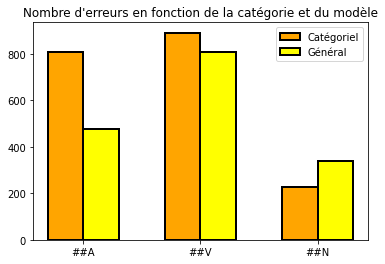

In [58]:
largeur_barre = 0.3 
y1 = liste_erreur_categ
y2 = liste_erreur_general
x1 = range(len(y1)) # Position des barres de la catégorie 1
x2 = [i + largeur_barre for i in x1] # Position des barres de la cat 2

b1 = plt.bar(x1, y1, width = largeur_barre, color = 'orange', # Barres cat 1
           edgecolor = 'black', linewidth = 2)
b2 = plt.bar(x2, y2, width = largeur_barre, color = 'yellow', # Barres cat 2
           edgecolor = ['black' for i in y1], linewidth = 2)
plt.xticks([r + largeur_barre / 2 for r in range(len(y1))], # Etiquettes
              ['##A', '##V', '##N'])
plt.legend([b1,b2], ['Catégoriel', 'Général'])
plt.title("Nombre d'erreurs en fonction de la catégorie et du modèle")
plt.show()

On peut observer sur la figure ci-dessus que le modèle du lemmatiseur catégoriel commet majoritairement un plus grand nombre d'erreurs que le lemmatiseur général. En effet, on voit que pour les adjectifs le modèle catégoriel a pratiquement le double d'erreurs que le modèle général. Sur la catégorie des verbes, cette différence tend à diminuer avec une augmentation du nombre d'erreurs du modèle général. Aussi, pour la catégorie des noms, on remarque que le modèle catégoriel est ici plus performant.  
Ces différences entre les deux modèles peuvent s'expliquer par le nombre d'exemples utilisés. Effectivement, le modèle catégoriel semble avoir besoin d'un plus grand nombre d'exemples que le modèle général pour être précis de manière générale. On voit tout de même que pour les noms le modèle général reste en-dessous des performances du modèle catégoriel.